# Image classification MNIST using pytorch

In [1]:
import torch
print(torch.__version__)

1.7.1


In [2]:
# both following 'device' will work
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using {} device".format(device))

Using cuda:0 device


## load data
Note that many old online/official examples have problems! 

There has been a lot of trouble (e.g., 503 error) with the MNIST hosted on http://yann.lecun.com/exdb/mnist/ (by default in torchvision.datasets.MNIST). Therefore pytorch got permission and hosting it now on amazon AWS. 

For window users, it is much easier just go to www.di.ens.fr/~lelarge/MNIST.tar.gz, download it, and unzip the file. Then you will have MNIST folder, which you put into the root directory for dataloader, e.g., ./data/

In [3]:
import torchvision
import torchvision.transforms as transforms

# for DataLoaders 
batch_size_train = 64
batch_size_test = 1000

# The values 0.1307 and 0.3081 used for the Normalize() transformation below are the 
# global mean and standard deviation of the MNIST dataset, we'll take them as a given here.
# Normalize(mean, std, inplace=False), i.e., output = (input - mean ) / std 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]) 

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                          shuffle=True, num_workers=2)

In [4]:
print(type(testset))
print(type(test_loader))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torch.utils.data.dataloader.DataLoader'>


Now let's take a look at some examples. We'll use the test_loader for this.

In [38]:
# enumerate wraps any iterator (or iterable conditioner) with a lazy generator
examples = enumerate(test_loader)

In [42]:
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx, example_data.shape)
print(batch_idx, example_targets.shape)

3 torch.Size([1000, 1, 28, 28])
3 torch.Size([1000])


torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


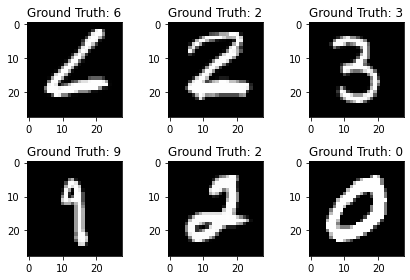

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  tmp = example_data[i][0]
  print(tmp.shape)
  plt.imshow(tmp, cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

## Building the Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

model by subclassing (recommended by pytorch)

In [9]:
# LeNet5 (with kenel=5) for the reduced-size MNIST (28*28) from original size (32*32) in the paper
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5) # 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 4 * 4, 120) #4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
#         x = x.view(-1, self.num_flat_features(x)) # flaten starting from dimension 1 
        x = torch.flatten(x, 1) # same with above, no extra function needed
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # added this line because using F.nll_loss to optimize
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] #all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# A larger network than LeNet5, one example of pytorch, 
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3) #(in_channels, out_channels, kernel_size, stride=1)
#         self.conv2 = nn.Conv2d(32, 64, 3)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2) # If the size is a square you can specify a single number
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output

In [10]:
network = Net().to(device)
print(network)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 'compile' the model 

In [11]:
# optimizer = optim.SGD(network.parameters(), lr= 0.01,momentum= 0.5)
optimizer = optim.Adam(network.parameters(), lr=0.0001)

#The negative log likelihood loss. It is useful to train a classification problem with C classes.
criterion = F.nll_loss 


In [12]:
n_epochs = 10
# store return values outside functions below:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []

In [13]:
def train(epoch):
    network.train() # switch to train mode
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # to GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        log_interval = 100
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        
          train_losses.append(loss.item())
            
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        
          torch.save(network.state_dict(), './results/model.pth')
          torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [14]:
def test():
    network.eval() # switch to evaluate mode
    
    test_loss = 0; correct = 0; acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) # to GPU
            
            output = network(data)
            test_loss += criterion(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        
    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)
    
    test_losses.append(test_loss)
    test_acc.append(acc)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset), 100. * acc))

## train the model 

In [15]:
import time
start_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
print('elapsed_time:',  time.time() - start_time) # 50s for 3 epochs on CPU

C:\Users\lwang\anaconda3\envs\py38_torch\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3043, Accuracy: 976/10000 (9.8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310900
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.025811
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.982934
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.626201
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.492371
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.384248
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.334168
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.412497
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.490086
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.246027

Test set: Avg. loss: 0.3039, Accuracy: 9114/10000 (91.1%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.344827
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.257905
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.231575
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.307075
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.472823
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.291809
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.104050
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.1

## Evaluate

Text(0, 0.5, 'negative log likelihood loss')

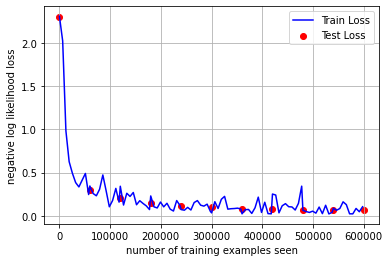

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red') 
plt.grid()
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


[tensor(0.9024, device='cuda:0') tensor(0.0886, device='cuda:0')
 tensor(0.0619, device='cuda:0') tensor(0.0463, device='cuda:0')
 tensor(0.0339, device='cuda:0') tensor(0.0300, device='cuda:0')
 tensor(0.0251, device='cuda:0') tensor(0.0263, device='cuda:0')
 tensor(0.0207, device='cuda:0') tensor(0.0202, device='cuda:0')
 tensor(0.0208, device='cuda:0')]


Text(0, 0.5, 'Test error rate')

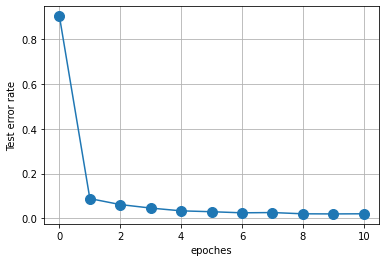

In [17]:
import numpy as np
error = 1-np.array(test_acc)
print(error)

fig = plt.figure()
plt.plot(error, 'o-', markersize=10, label='error rate') #linewidth=1 
plt.grid()
plt.xlabel('epoches')
plt.ylabel('Test error rate')

In [18]:
def view_classify(img, ps):
    # Function for viewing an image and it's predicted classes.
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout() 

In [49]:
examples = iter(test_loader) # iter() makes an iterator 
print('iterator @', examples) 
print(iter(test_loader)==iter(test_loader)) # test_loader is not iterator (but iterable)
print(iter(examples)==iter(examples)) # examples is iterator

(images, labels) = next(examples)
print(images.shape)
print(labels.shape)

#%% result on one test sample
img = images[9]
print('imag:', img.shape)
img = img.unsqueeze(0) # add one dimension 
print('imag:', img.shape)


iterator @ <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x000001971FF912E0>
False
True
torch.Size([1000, 1, 28, 28])
torch.Size([1000])
imag: torch.Size([1, 28, 28])
imag: torch.Size([1, 1, 28, 28])


Predicted Digit = 5


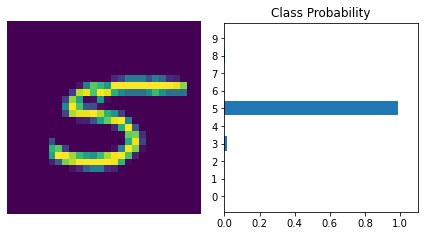

In [50]:
# Turn off gradients to speed up
with torch.no_grad():
    logps = network(img.to(device)) # GPU

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

view_classify(img.view(1, 28, 28), ps) 
